Simple example of using evolution strategies inside `es.py` for toy deterministic fitness function.

In [1]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import cma
from es import SimpleGA, CMAES, PEPG, OpenES

In [2]:
#constants
XFINAL = 10.0
YFINAL = -5.
DIST = np.sqrt(XFINAL**2+YFINAL**2)
g = -9.8 #m/s^2
#k = 1
K = 2.585999608432 #radius of the cycloid of the real brachistochrone. Gotten numerically from Mathematica
TFINAL = 3.50837   #final angle of the cycloid of the real brachistochrone. Gotten numerically from Mathematica
#FindRoot[Evaluate[{a*(t - Sin[t]) == XFINAL, a*(1 - Cos[t]) == YFINAL}], {a, 5}, {t, 3.2}, MaxIterations -> 1000]

The equation of a cycloid is
$$ \left(\frac{dy}{dx}\right)^2 = \frac{2k-y}{y} $$
Cycloids cannot be expressed in closed form, but can be expressed in parametric form. 
$$ x = k(\theta-\sin\theta) $$
$$ y = k(1-\cos\theta) $$
You can get the fourier coeffcients in a series expansion
$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x)cos(\frac{nx}{2 k}) dx $$
$$ b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x)sin(\frac{nx}{2 k}) dx $$

Change all the variables to $\theta$:

$$ a_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \cos(\frac{n}{2} (\theta-\sin{\theta})) d\theta $$
$$ b_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \sin(\frac{n}{2} (\theta-\sin{\theta})) d\theta = 0 $$ 

All the $b_n$ will be zero because the cycloid is an even function.

We can then find the coeffcients and plug them into the 
 

In [3]:
def cycloid_coefficients(n,r):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints. 
    # change of variables to theta is necessary since cannot write in terms of y(x).
    # sine terms are all 0. cosine terms are non-zero.
    coefs = [0]*(2*n+1)
    def cos_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.cos((c/2.)*(theta-np.sin(theta))))
    def sin_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.sin((c/2.)*(theta-np.sin(theta))))
    for i in range(n):
        coefs[2*i] = -1.0*(r/(2.*np.pi))*integrate.quad(lambda x: cos_coef(i,x),-2*np.pi,2*np.pi,limit=200)[0]
        coefs[2*i+1] = 0
    coefs[0] = coefs[0]/2.0
    coefs[2*n] = -1.0*(r/(2.*np.pi))*integrate.quad(lambda x: cos_coef(n,x),-2*np.pi,2*np.pi,limit=200)[0]
    return np.array(coefs)

def line_coefficients(n,r):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints.
    # The line starts at (0,0) and ends at (XFINAL,YFINAL)
    # all Cosine terms are 0. Sine terms non-zero
    coefs = [0.0]*(2*n+1)
    def cos_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.cos(c*theta/(2.*r)))
    def sin_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.sin(c*theta/(2.*r)))
    for i in range(n):
        coefs[2*i] = 0.0
        coefs[2*i+1] = (1.0/(2.*np.pi*r))*integrate.quad(lambda x: sin_coef(i+1,x),-2*np.pi*r,2*np.pi*r,limit=200)[0]
    return np.array(coefs)

In [4]:
def f(c_list,x):
    # Given a list of coefficients c_list, f(x) is the fourier expansion 
    # f(x) = a0 + sum(an*cos(nx) + bn*sin(nx))
    # even entries in c_list are the a_n, odd entries are the b_n. c_list should always have len(c_list) = odd.
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([np.cos(x*n/(2.*k)) for n in range(len(a))])
    sines = np.array([np.sin(x*n/(2.*k)) for n in range(1,len(b)+1)])
    result = (np.dot(a,cosines)+np.dot(b,sines))
    # the result cannot have f(x) > 0 due to conservation of energy
    if np.isscalar(result):
        return result if result < 0 else -0.00001
    return np.array([i if i < 0 else -0.00001 for i in result])

def fp(c_list,x):
    #derivative of the function f(x)
    #f' = sum(n*bn*cos(nx)-n*an*sin(nx))
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([(n/(2.*k))*np.cos(x*n/(2.*k)) for n in range(1,len(b)+1)])
    sines = np.array([-(n/(2.*k))*np.sin(x*n/(2.*k)) for n in range(1,len(a))])
    result = np.dot(a[1:],sines)+np.dot(b,cosines)
    return result

In [5]:
def delta_time(c_list):
    c_list = np.copy(c_list)
    def cost(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fp(c_list,x)**2)/(2.0*g*f(c_list,x)))
    time = integrate.quad(cost,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    #we also want to constrain the path to begin at (0,0) and end at (XFINAL,YFINAL)
    begin_penalty = (f(c_list,0.0001)-(-0.00001))**2
    end_penalty = (f(c_list,XFINAL)-YFINAL)**2
    return -1.*time-begin_penalty-end_penalty

fit_func = delta_time 

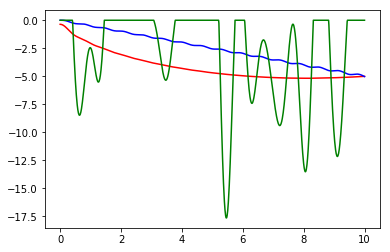

OPTMAL:
  fitness: -1.67800911006
  distance at x=0: 0.36325077214527934 distance at x=XFINAL: 0.004722838088501824
  penalty at x=0: 0.047931347483786545 penalty at x=XFINAL: 1.0534384629070542e-07
LINE:
  fitness: -17.7652907923
  distance at x=0: 0.0 distance at x=XFINAL: 0.02370058213363979
  penalty at x=0: 0.0 penalty at x=XFINAL: 1.3313033960026939e-05
RANDOM:
  fitness: -10156.222104941027
  distance at x=0: 0.0 distance at x=XFINAL: 4.99999
  penalty at x=0: 0.0 penalty at x=XFINAL: 124.99925000150003


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [7]:
%matplotlib inline
import math

xaxis = np.linspace(0, XFINAL, 1000)

optimal_coefs = cycloid_coefficients(50,k)
line_coefs = line_coefficients(50,k)
rand_coefs = np.random.randn(101)

yaxis_opt = f(optimal_coefs,xaxis)
yaxis_line = f(line_coefs,xaxis)
yaxis_rand = f(rand_coefs,xaxis)
ypaxis_opt = fp(optimal_coefs,xaxis)
ypaxis_line = fp(line_coefs,xaxis)
ypaxis_rand = fp(rand_coefs,xaxis)
plt.plot(xaxis, yaxis_opt, "r")
#plt.plot(xaxis, ypaxis_opt, "r+")
plt.plot(xaxis, yaxis_line, "b")
#plt.plot(xaxis, ypaxis_line, "b+")
plt.plot(xaxis, yaxis_rand, "g")
#plt.plot(xaxis, ypaxis_rand, "g+")
plt.show()

def dist_penalty(yax):
    begin_dist = math.fabs(yax[0]-(-0.00001))
    end_dist = math.fabs(yax[-1]-(YFINAL))
    begin_penalty = begin_dist**3
    end_penalty = end_dist**3
    print('  distance from x=0:',begin_dist,'distance from x=XFINAL:',end_dist)
    print('  penalty at x=0:',begin_penalty,'penalty at x=XFINAL:',end_penalty)

print('OPTMAL:')
print('  fitness:',delta_time(optimal_coefs))
dist_penalty(yaxis_opt)
print('LINE:')
print('  fitness:',delta_time(line_coefs))
dist_penalty(yaxis_line)
print('RANDOM:')
print('  fitness:',delta_time(rand_coefs))
dist_penalty(yaxis_rand)

In [15]:
NPARAMS = 101     # make this a 101-dimensinal problem.
NPOPULATION = 50    # use population size of 50.
MAX_ITERATION = 100 # run each solver for 1000 generations.

In [16]:
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append((result[0],result[1]))
        if (j+1) % 2 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history

These are the 101 fourier coefficients for the optimal cycloid:
[ -3.87899941e+00   0.00000000e+00   8.33211591e-17   0.00000000e+00
   1.68166055e+00   0.00000000e+00   1.04256913e-15   0.00000000e+00
   5.78981467e-01   0.00000000e+00  -3.53577810e-16   0.00000000e+00
   3.05197154e-01   0.00000000e+00   6.49041441e-17   0.00000000e+00
   1.92711806e-01   0.00000000e+00   9.38778169e-16   0.00000000e+00
   1.34566952e-01   0.00000000e+00   1.95492020e-15   0.00000000e+00
   1.00207667e-01   0.00000000e+00  -1.38327890e-15   0.00000000e+00
   7.80329338e-02   0.00000000e+00   6.38569319e-15   0.00000000e+00
   6.27971807e-02   0.00000000e+00  -1.20578029e-15   0.00000000e+00
   5.18271616e-02   0.00000000e+00  -1.70252705e-15   0.00000000e+00
   4.36359395e-02   0.00000000e+00   5.29695126e-15   0.00000000e+00
   3.73391170e-02   0.00000000e+00   3.25435209e-15   0.00000000e+00
   3.23820163e-02   0.00000000e+00  -3.80120063e-15   0.00000000e+00
   2.84014367e-02   0.00000000e+00   1.

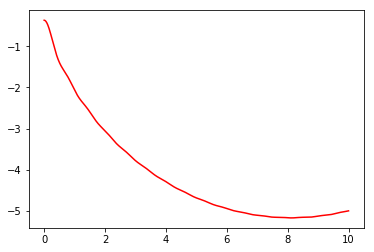

delta time: 1.67800911006


In [17]:
x = optimal_coefs
print("These are the",len(x),"fourier coefficients for the optimal cycloid:")
print(x)
yaxis = f(x,xaxis)
plt.plot(xaxis, yaxis, "r")
plt.show()
print('delta time:',-delta_time(x))

These are the 101 fourier coefficients for starting with a line:
[ 0.         -5.17199922  0.          2.58599961  0.         -1.72399974
  0.          1.2929998   0.         -1.03439984  0.          0.86199987
  0.         -0.73885703  0.          0.6464999   0.         -0.57466658
  0.          0.51719992  0.         -0.47018175  0.          0.43099993
  0.         -0.39784609  0.          0.36942852  0.         -0.34479995
  0.          0.32324995  0.         -0.30423525  0.          0.28733329
  0.         -0.27221049  0.          0.25859996  0.         -0.24628568
  0.          0.23509087  0.         -0.22486953  0.          0.21549997
  0.         -0.20687997  0.          0.19892305  0.         -0.19155553
  0.          0.18471426  0.         -0.1783448   0.          0.17239997
  0.         -0.16683868  0.          0.16162498  0.         -0.15672725
  0.          0.15211762  0.         -0.14777141  0.          0.14366664
  0.         -0.13978376  0.          0.13610524  0.       

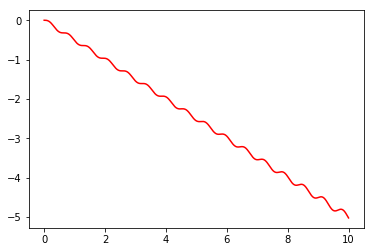

delta time: 17.7652907923


In [18]:
x = line_coefs
print("These are the",len(x),"fourier coefficients for starting with a line:")
print(x)
yaxis = f(x,xaxis)
plt.plot(xaxis, yaxis, "r")
plt.show()
print('delta time:',-delta_time(x))

In [ ]:
# defines genetic algorithm solver
ga = SimpleGA(NPARAMS,                # number of model parameters
               sigma_init=0.5,        # initial standard deviation
               popsize=NPOPULATION,   # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               weight_decay=0.00,     # weight decay coefficient
              )

In [ ]:
ga_history = test_solver(ga)

In [19]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.05
          )

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 101 (seed=276731, Wed Sep  5 18:44:11 2018)


In [ ]:
cma_history = test_solver(cmaes)


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 2 -363.5763643648625
fitness at iteration 4 -169.57712299724636
fitness at iteration 6 -120.08261269170839
fitness at iteration 8 -36.735001018453225


In [ ]:
x = [-1.29036542, -0.62896731, -0.63294334, -0.60527331, -0.14701905,  0.25665035,
 -0.13045431,  0.26704472, -0.26891076, -0.15870245,  0.05435706, -0.06045987,
  0.07657396,  0.07607268, -0.23299025, -0.01144153,  0.02903827,  0.02299654,
  0.09933435,  0.06244944, -0.05982582, -0.13206807,  0.09358589,  0.02678654,
  0.00486741, -0.25947983,  0.04774933, -0.07890868, -0.12154341,  0.02266455,
 -0.02032519,  0.16915864,  0.07331226, -0.18020797, -0.02328137,  0.0603857,
 -0.11221066, -0.09890188,  0.00446266, -0.01555902, -0.29934881,  0.17894661,
 -0.05831651,  0.07701741,  0.03371479,  0.18500557, -0.01014909, -0.18913945,
 -0.0962447,   0.52413548, -0.18132617,  0.01423729,  0.25842228, -0.05110348,
  0.07742499,  0.13401056, -0.15829474,  0.04285918,  0.34400224, -0.23677707,
 -0.22129372,  0.13702365, -0.0594799,   0.18952237,  0.0914457,  -0.03144436,
  0.00157056,  0.24221882,  0.15308777,  0.04845059,  0.2153165,  -0.24238401,
  0.24121954,  0.01216627, -0.06689987, -0.16477422,  0.3130532,  -0.28739197,
 -0.13205555, -0.12809294, -0.02251622, -0.06776406, -0.22349353,  0.14377631,
  0.00802508, -0.11824727, -0.0263068,   0.04247671,  0.11445536, -0.10857525,
 -0.23131561,  0.02237699,  0.02945924,  0.09478949, -0.05308294, -0.13201993,
  0.0084653,   0.20703085, -0.05692335, -0.04486629,  0.09116252]
print(delta_time(x))
yaxis = f(x,xaxis)
ypaxis = fp(x,xaxis)
plt.plot(xaxis, yaxis, "r")
#plt.plot(xaxis, ypaxis, "b")
plt.show()

In [ ]:
# defines PEPG (NES) solver
pepg = PEPG(NPARAMS,                         # number of model parameters
            sigma_init=0.5,                  # initial standard deviation
            learning_rate=0.1,               # learning rate for standard deviation
            learning_rate_decay=1.0,       # don't anneal the learning rate
            popsize=NPOPULATION,             # population size
            average_baseline=False,          # set baseline to average of batch
            weight_decay=0.00,            # weight decay coefficient
            rank_fitness=False,           # use rank rather than fitness numbers
            forget_best=False)            # don't keep the historical best solution)

In [ ]:
pepg_history = test_solver(pepg)

In [ ]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.5,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.1,         # learning rate for standard deviation
            learning_rate_decay = 1.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=False)

In [ ]:
oes_history = test_solver(oes)

In [ ]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
# this version turns on antithetic sampling. It doesn't really help, and sometimes hurts performance.
oes_antithetic = OpenES(NPARAMS,            # number of model parameters
                 sigma_init=0.5,            # initial standard deviation
                 sigma_decay=0.999,         # don't anneal standard deviation
                 learning_rate=0.1,         # learning rate for standard deviation
                 learning_rate_decay=1.0,   # annealing the learning rate
                 popsize=NPOPULATION+1,     # population size
                 antithetic=True,           # whether to use antithetic sampling
                 weight_decay=0.00,         # weight decay coefficient
                 rank_fitness=False,        # use rank rather than fitness numbers
                 forget_best=False)

In [ ]:
oes_antithetic_history = test_solver(oes_antithetic)

In [ ]:
# Create a new figure of size 8x6 points, using 100 dots per inch
best_history = [0] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

optimum_line, = plt.plot(best_history, color="black", linewidth=0.5, linestyle="-.", label='Global Optimum')
ga_line, = plt.plot(ga_history, color="green", linewidth=1.0, linestyle="-", label='GA')
oes_line, = plt.plot(oes_history, color="orange", linewidth=1.0, linestyle="-", label='OpenAI-ES')
pepg_line, = plt.plot(pepg_history, color="blue", linewidth=1.0, linestyle="-", label='PEPG / NES')
cma_line, = plt.plot(cma_history, color="red", linewidth=1.0, linestyle="-", label='CMA-ES')

plt.legend(handles=[optimum_line, ga_line, cma_line, pepg_line, oes_line], loc=4)

# Set x limits
plt.xlim(0,2500)

plt.xlabel('generation')
plt.ylabel('fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()